In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Ex. 1 (Q7): Noisy signal

In [4]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

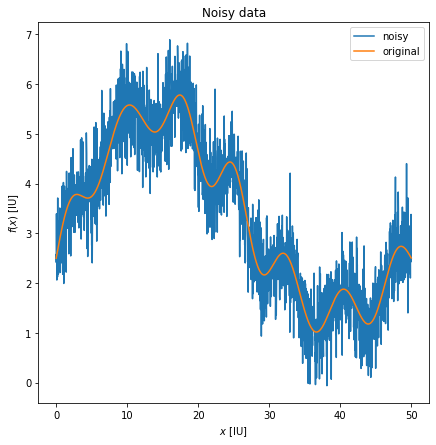

In [11]:
fig = plt.figure(figsize=(7,7))

plt.plot(x, noisy,label='noisy')
plt.plot(x, orig, label='original')
plt.xlabel(r'$x$ [IU]')
plt.ylabel(r'$f(x)$ [IU]')
plt.title('Noisy data')
plt.legend()

SciPy provides a convolution function _scipy.signal.convolve()_ that can do the convolution for us directly. To smooth the data, we want to use a Gaussian, which can be produced by _scipy.signal.window.gaussian()_.

Convolve the noisy data with a Gaussian and plot the result together with the original data _orig_. You'll need to play with the width of the Gaussian to get a nice smoothing. You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

In [21]:
import scipy.signal

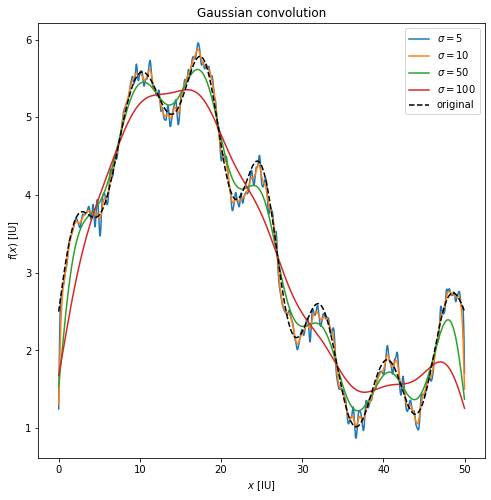

In [69]:
fig = plt.figure(figsize=(8,8))

sigmas = np.array([5,10,50,100])

for s in sigmas:
    
    # create the gaussian window:
    norm_gauss = 1/(s*np.sqrt(2*np.pi))

    gauss_window = norm_gauss*scipy.signal.windows.gaussian(len(noisy),s,sym=False)

    # convolve the noisy signal with the Gaussian window:
    convolution = scipy.signal.convolve(noisy,gauss_window,mode='same',method='fft')
    
    # plot
    plt.plot(x,convolution,label=r'$\sigma=%.i$'%s)
    
plt.plot(x,orig,color='black',label='original',ls='--')
plt.title('Gaussian convolution')
plt.xlabel(r'$x$ [IU]')
plt.ylabel(r'$f(x)$ [IU]')
plt.legend()

# Ex.2 (Q8): FFT of the chaotic pendulum

Here we want to examine the behavior of the chaotic pendulum in frequency space. The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [70]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum. For a small amplitude, since we have $L=g$ in our pendulum, the period is simply $T=2\pi$, and the frequency is $\nu_k=1/2\pi$. We plot things in terms of the angular frequency $\omega_k = 2\pi\nu_k$, so all the power will be at $\omega_k=1$.

In [106]:
t,y = int_pendulum(np.radians(10),0.0,0.6666,0.5,200.0,0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it. Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic. For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

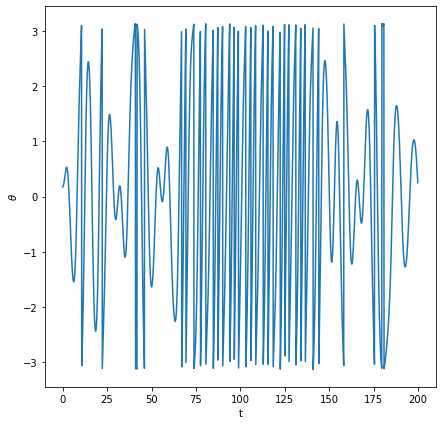

In [107]:
fig = plt.figure(figsize=(7,7))

plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [108]:
def power_spectrum(t,theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta
    
    # compute the FFT
    Fk = np.fft.rfft(theta)
    
    # normalize:
    n_pts = len(t)
    norm_fft = 2.0/n_pts
    Fk = norm_fft*Fk
    
    Fk_r = Fk.real
    Fk_i = Fk.imag
    
    # get the frequency
    k = np.fft.rfftfreq(n_pts)
    kfreq = k*n_pts/(max(t)+t[1])
    omega_k = 2*np.pi*kfreq
    
    return omega_k, Fk_r, Fk_i

In [109]:
omega_k, FT_r, FT_i = power_spectrum(t,restrict_theta(y[0,:]))

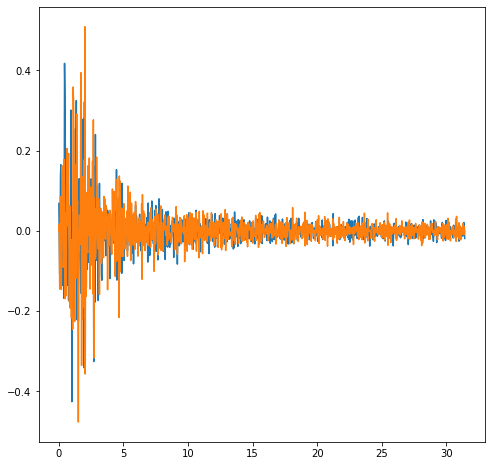

In [110]:
fig = plt.figure(figsize=(8,8))

plt.plot(omega_k,FT_r)
plt.plot(omega_k,FT_i)